In [2]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# This model will use tensorflows functional API which is better for hard core deep learning models as 
# opposed to TF's sequential API
# The model we are building is called a siamese neural network, which allows us to do one shot classification.
# https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf

# Import standard tensorflow dependencies - Funtional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [4]:
# Only use if training o a GPU based machine. This notebook will be trained using google co lab
# Avoid out of memory errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
gpus

[]

In [5]:
# Setup paths
POS_PATH = os.path.join('../raw_data', 'positve')
NEG_PATH = os.path.join('../raw_data', 'negative')
ANC_PATH = os.path.join('../raw_data', 'anchor')

In [11]:
DATA_PATH = os.path.join('../raw_data', 'data')

In [ ]:
# Make directories
os.mkdir(POS_PATH)
os.mkdir(NEG_PATH)
os.mkdir(ANC_PATH)

In [ ]:
os.mkdir(DATA_PATH)

In [ ]:
# Downloaded images as zipped tar file from http://vis-www.cs.umass.edu/lfw/
# Command below unzips tar file and saves in data directory
!tar -xf ../raw_data/lfw.tgz -C ../raw_data/data

In [ ]:
# Move LFW images to the following repository ../raw_data/negative

for directory in os.listdir('../raw_data/data/lfw'):
    for file in os.listdir(f'../raw_data/data/lfw/{directory}'):
        EX_PATH = os.path.join('../raw_data/data/lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [6]:
import uuid

In [7]:
# Establish connection to webcam

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    # cut down frame to 250x250px
    frame = frame[270:270+250,650:650+250, :]
    
    # Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
        #cv2.waitKey(1)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    # show image back to screen
    cv2.imshow('Image Collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# Release the webcam
cap.release()

# Close the image show frame
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

In [8]:
frame.shape


(250, 250, 3)

In [ ]:
#plt.imshow(frame[270:270+250,650:650+250, :])

In [ ]:
#plt.imshow(frame[120:120+250,200:200+250, :])

In [14]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [36]:
anchor.

tensorflow.python.data.ops.dataset_ops.TakeDataset

In [15]:
dir_test = anchor.as_numpy_iterator()

In [19]:
dir_test.next()

b'../raw_data/anchor/e564489a-cbe6-11ec-95bd-acde48001122.jpg'

Preprocessing - scale and resize

In [22]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img / 255.0
    return img

In [24]:
dir_test_img = preprocess('../raw_data/anchor/e564489a-cbe6-11ec-95bd-acde48001122.jpg')

In [27]:
dir_test_img.numpy().min()

0.005882353

In [ ]:
dir_test_img.numpy().min()

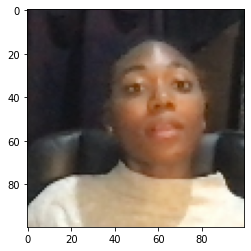

In [25]:
plt.imshow(dir_test_img)

In [ ]:
dataset.map(preprocess)

create labeled images

In [ ]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [37]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)